In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("leaguedata.csv")
df

,game_id,role,kill,death,assist,gold_earned,champion_level,total_damage_dealt,total_damage_dealt_to_champions,vision_score,...,laning_score,is_win,rift_herald_kill,rift_herald_first,dragon_kill,dragon_first,baron_kill,baron_first,tower_kill,horde_kill
0,0.0,my_top,5.0,5.0,12.0,12666.0,17.0,199661.0,38439.0,21.0,...,5.364805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,my_jungle,2.0,4.0,4.0,14072.0,17.0,329327.0,7355.0,31.0,...,5.257720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,my_mid,6.0,8.0,13.0,13334.0,17.0,198326.0,31908.0,15.0,...,5.058014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,my_adc,16.0,9.0,5.0,16681.0,16.0,224340.0,36159.0,16.0,...,4.941986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,my_support,4.0,5.0,9.0,9402.0,14.0,26113.0,8915.0,33.0,...,4.370815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,18.0,enemy_mid,15.0,3.0,3.0,14653.0,16.0,165917.0,25601.0,24.0,...,6.270399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
224,18.0,enemy_adc,19.0,6.0,15.0,15697.0,15.0,125222.0,39337.0,12.0,...,7.232967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
225,18.0,enemy_support,12.0,7.0,17.0,10719.0,13.0,37354.0,24711.0,62.0,...,6.686526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,18.0,my_team,NaN,NaN,NaN,49507.0,NaN,NaN,NaN,NaN,...,NaN,False,1.0,True,2.0,True,0.0,False,4.0,3.0


# This bar chart shows the average gold earned in games that I win.

<Axes: xlabel='role'>

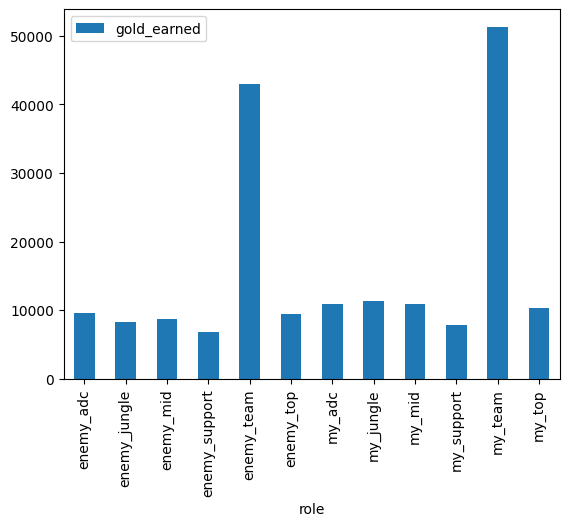

In [3]:
win_game_ids = df.loc[
    (df['role'] == 'my_team') & df['is_win'],
    'game_id'
].unique()
df['i_won'] = df['game_id'].isin(win_game_ids)
df.loc[df['i_won']].groupby(['role', 'i_won'])['gold_earned'].mean().reset_index().plot.bar(
    x="role",
    y="gold_earned"
)

# This bar chart shows the average gold earned in games that I lose

<Axes: xlabel='role'>

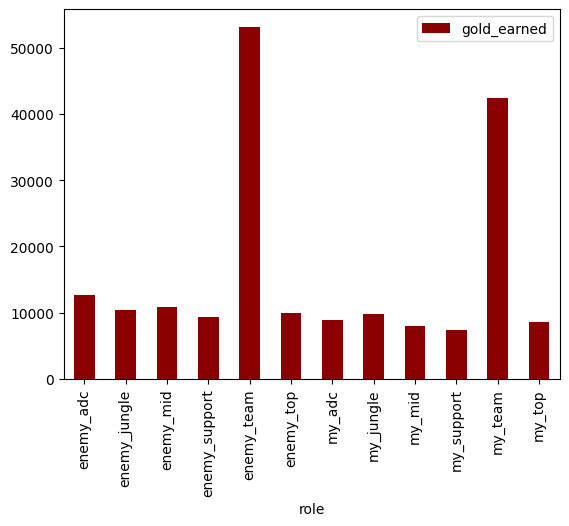

In [4]:
lose_game_ids = df.loc[~df.i_won, 'game_id'].unique()
df.loc[~df.i_won].groupby('role').gold_earned.mean().reset_index().plot.bar(
    x = "role",
    y = "gold_earned",
    color = "darkred"
)

# Average difference in gold when I win
As we can easily see, when I win my role has the most amount of gold differential. This is likely because I am usually the **greatest** player on my team, duh.

<Axes: >

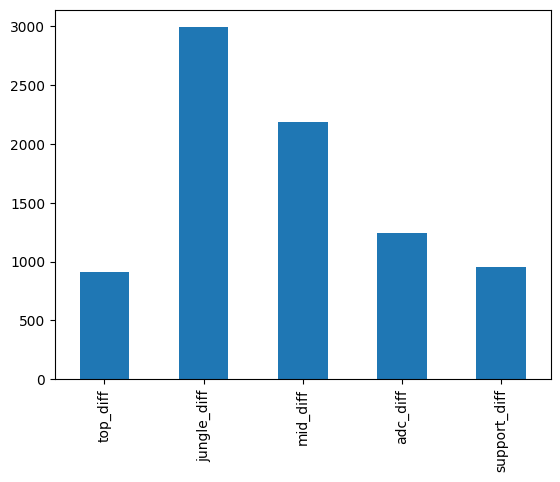

In [5]:
# This plots the average difference in gold in each role when I win
ga = df.loc[df.i_won].groupby('role').gold_earned.mean()
pd.Series([ga.my_top - ga.enemy_top, ga.my_jungle - ga.enemy_jungle, ga.my_mid - ga.enemy_mid, ga.my_adc - ga.enemy_adc, 
           ga.my_support - ga.enemy_support], index = ['top_diff', 'jungle_diff', 'mid_diff', 'adc_diff', 'support_diff']).plot.bar()

# Average difference in gold when I lose
As we can see, when I lose my role has the least amount of gold differential, while the mid and adc roles have much higher differences. This could mean that the adc and mid roles are the most likely to lose the game for the team. However, it could also be explained by the "Snowballing" nature of these roles in the game. Let's look to these role's difference in laning score for more insight later.

<Axes: >

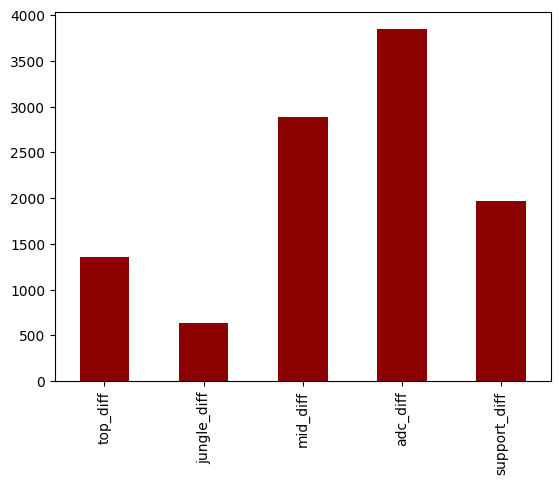

In [6]:
ga = df.loc[~df.i_won].groupby('role').gold_earned.mean()
pd.Series([ga.enemy_top - ga.my_top, ga.enemy_jungle - ga.my_jungle, ga.enemy_mid - ga.my_mid, ga.enemy_adc - ga.my_adc, 
           ga.enemy_support - ga.my_support], index = ['top_diff', 'jungle_diff', 'mid_diff', 'adc_diff', 'support_diff']).plot.bar(color = "darkred")